# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug --quiet
!pip install pip --upgrade --quiet
!pip install ipywidgets --quiet
# !pip install torchvision

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
bucket

'sagemaker-us-east-1-328945632120'

## Dataset

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-05-16 18:13:11--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  36.8MB/s    in 35s     

2022-05-16 18:13:48 (31.3 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

**Note**: It's important you either delete this file in the **train** dataset or pass it into an error handler: Leonberger_06571.jpg. It might be quite large and it causes issues. ImageFile.LOAD_TRUNCATED_IMAGES = True might also help in the hpo.py script

In [6]:
# Let's explore our files | Source @Skysign: https://bit.ly/3CZRzg5
import numpy as np
from glob import glob
dog_files = np.array(glob("dogImages/*/*/*"))
training_dog_files = np.array(glob("dogImages/train/*/*"))
test_dog_files = np.array(glob("dogImages/test/*/*"))
validation_dog_files = np.array(glob("dogImages/valid/*/*"))

print('There are %d total dog images.' % len(dog_files))
print('There are %d total dog images in training set.' % len(training_dog_files))
print('There are %d total dog images in test set.' % len(test_dog_files))
print('There are %d total dog images in validation set.' % len(validation_dog_files))

There are 8351 total dog images.
There are 6680 total dog images in training set.
There are 836 total dog images in test set.
There are 835 total dog images in validation set.


In [5]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/dogImages/train/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/dogImages/test/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/dogImages/valid/

## Hyperparameter Tuning

In [4]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [5]:
objective_metric_name = "Test Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Test Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [6]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=2,
    base_job_name="predict-dogImages",
    instance_type="ml.c5.2xlarge" # "ml.m5.large" | ml.p3.2xlarge (very expensive) | ml.c5.2xlarge	
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2, #change as needed
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [7]:
tuner.fit()

................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>

In [8]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220516-1957') #	pytorch-training-220516-1957-001-c5e815eb

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch-size        lr                            TrainingJobName  \
1      "512"  0.003004  pytorch-training-220516-1957-001-c5e815eb   
0       "64"  0.030159  pytorch-training-220516-1957-002-ce35716e   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed                 86.0 2022-05-16 19:59:18+00:00   
0         Completed                  0.0 2022-05-16 19:59:32+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2022-05-16 20:28:09+00:00                      1731.0  
0 2022-05-16 20:28:07+00:00                      1715.0

<h3>Prepare to perform Training on Best Estimator</h3>

In [9]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-06-13 16:34:17 Starting - Preparing the instances for training
2022-06-13 16:34:17 Downloading - Downloading input data
2022-06-13 16:34:17 Training - Training image download completed. Training in progress.
2022-06-13 16:34:17 Uploading - Uploading generated training model
2022-06-13 16:34:17 Completed - Training job completed


{'_tuning_objective_metric': '"Test Accuracy"',
 'batch-size': '"512"',
 'lr': '0.004120510525842499',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"predict-dogImages-2022-06-13-16-00-50-190"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-328945632120/predict-dogImages-2022-06-13-16-00-50-190/source/sourcedir.tar.gz"'}

In [10]:
# let's pass our hyperparams programmatically into the profiling and debugging steps
hyper_params = best_estimator.hyperparameters()
# Let's pass in our hyper_params
# Change epoch size as needed
# Note batch size is string likely because it's passed in as categorical parameter
hyperparameters = {"batch-size": hyper_params['batch-size'].replace('"',""), "lr": hyper_params["lr"]}
hyperparameters

{'batch-size': '512', 'lr': '0.004120510525842499'}

## Model Profiling and Debugging

In [11]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [12]:
### Multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='predict-dogImage',
    role=role,
    instance_count=2,
    instance_type= "ml.m5.4xlarge", # "ml.m5.xlarge",ml.m5.4xlarge is ($0.922/hr per: https://aws.amazon.com/sagemaker/pricing/)
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [13]:
estimator.fit(wait=True)

2022-06-13 16:46:04 Starting - Starting the training job...
2022-06-13 16:46:25 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-06-13 16:48:03 Downloading - Downloading input data
2022-06-13 16:48:03 Training - Downloading the training image......
2022-06-13 16:49:03 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-13 16:48:52,678 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-13 16:48:52,681 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-06-13 16:48:52,689 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-

In [14]:
boto_session_obj = boto3.session.Session()
region = boto_session_obj.region_name
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: predict-dogImage-2022-06-13-16-46-03-785
Region: us-east-1


In [15]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-328945632120/predict-dogImage-2022-06-13-16-46-03-785/rule-output


In [16]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-06-13 17:14:54     365033 predict-dogImage-2022-06-13-16-46-03-785/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-06-13 17:14:53     212101 predict-dogImage-2022-06-13-16-46-03-785/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-06-13 17:14:48        192 predict-dogImage-2022-06-13-16-46-03-785/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-06-13 17:14:48        200 predict-dogImage-2022-06-13-16-46-03-785/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-06-13 17:14:48       2044 predict-dogImage-2022-06-13-16-46-03-785/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-06-13 17:14:48        127 predict-dogImage-2022-06-13-16-46-03-785/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-06-13 17:14:48        199 predict-dogImage-2022-06-13-16-46-03-785/rule-output/ProfilerReport/profiler-output/profiler-re

In [17]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [18]:
estimator.model_data

's3://sagemaker-us-east-1-328945632120/predict-dogImage-2022-06-13-16-46-03-785/output/model.tar.gz'

In [19]:
model_location=estimator.model_data

In [20]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
import numpy as np

In [21]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [22]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [23]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-------!

In [24]:
from PIL import Image
import io

In [25]:
img_path = './dogImages/valid/012.Australian_shepherd/Australian_shepherd_00808.jpg'
image = Image.open(img_path).convert('RGB')  


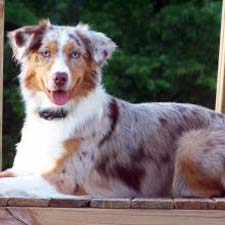

In [26]:
image

In [27]:
image = Image.open(img_path).convert('RGB')  

img_bytes = io.BytesIO()
image.save(img_bytes, format='PNG')
img_bytes = img_bytes.getvalue()
# img_bytes

In [28]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
predicted_class_idx = np.argmax(response, 1)
predicted_class_idx[0]

75

Let's get our classes to evaluate our predictions

In [29]:
bucket

'sagemaker-us-east-1-328945632120'

In [30]:
import pickle
import boto3

s3 = boto3.resource('s3')
pkl_key = "dogImages/classes/dog_breeds_labels.pkl"
classes = pickle.loads(s3.Bucket(bucket).Object(pkl_key).get()['Body'].read())
classes[0:5]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute']

In [31]:
classes[predicted_class_idx[0]] #fantastic!

'Golden retriever'

In [32]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Italian_Greyhound_standing_gray_%28cropped%29.jpg/1200px-Italian_Greyhound_standing_gray_%28cropped%29.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

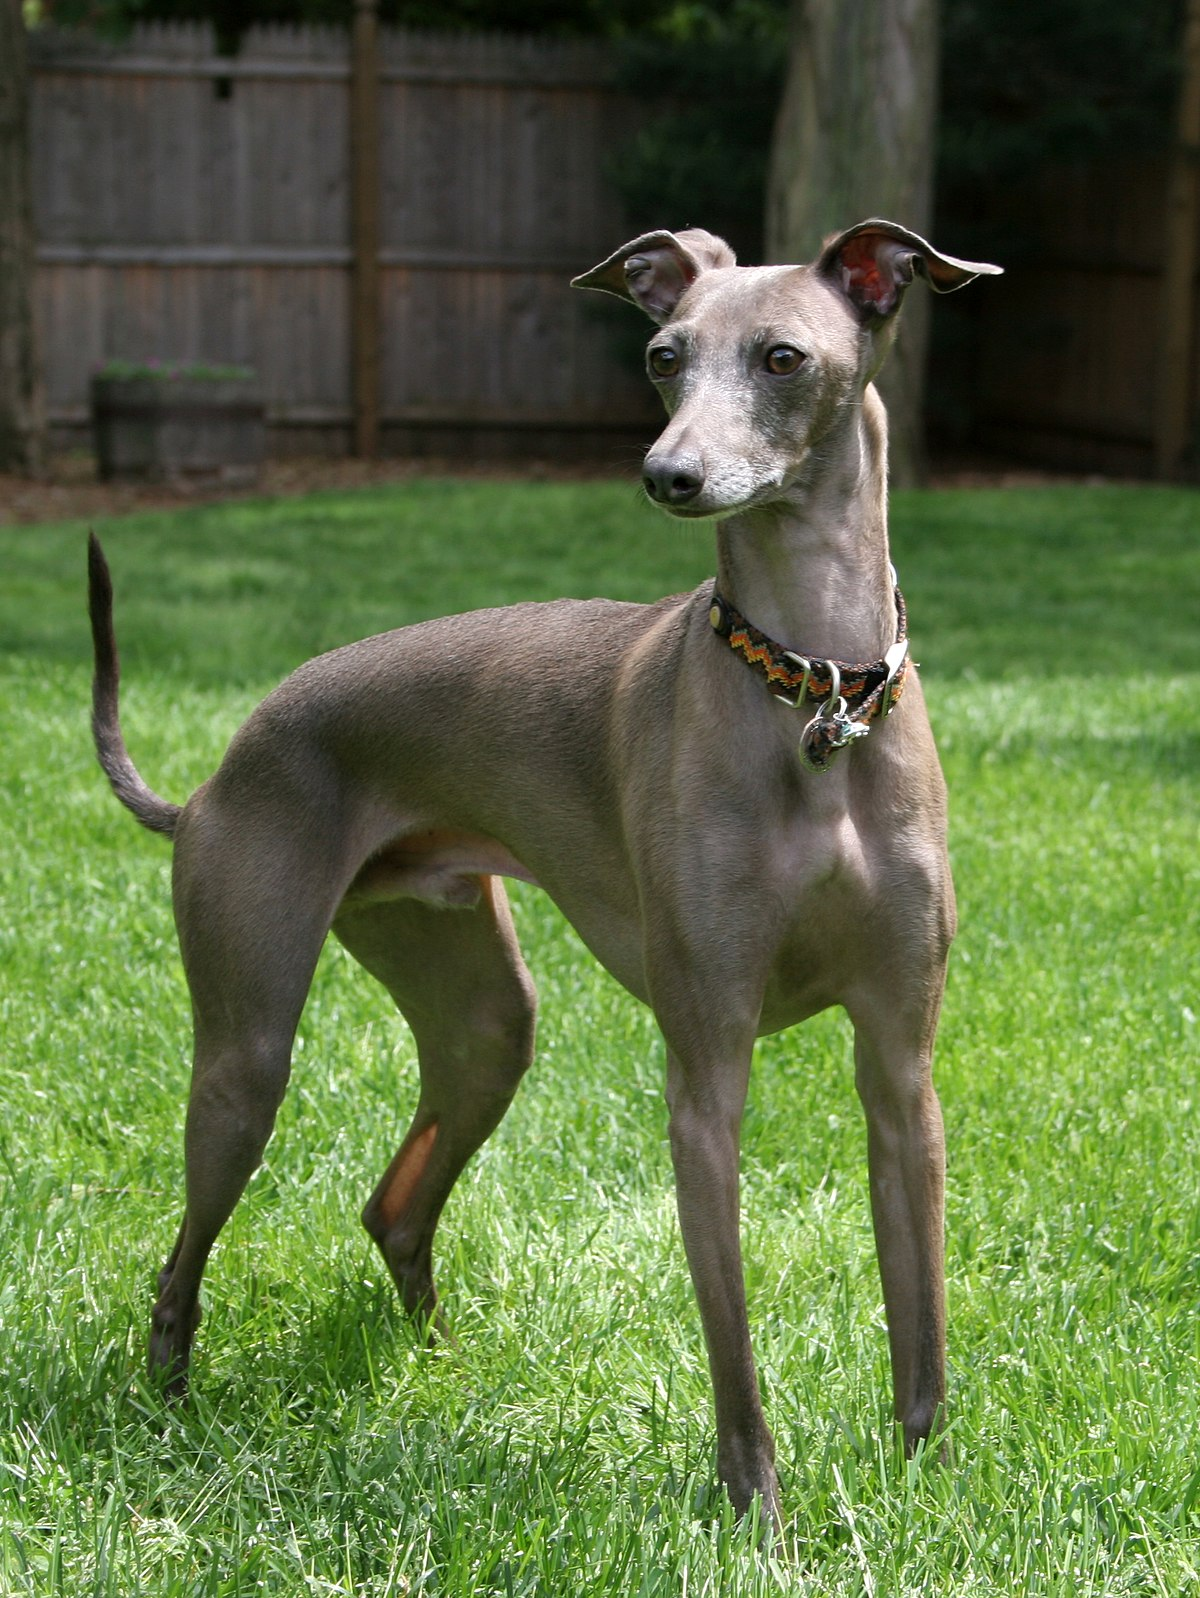

In [33]:
Image.open(io.BytesIO(img_bytes))

In [34]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
predicted_class_idx = np.argmax(response, 1)
predicted_class_idx[0]
classes[predicted_class_idx[0]]

'Italian greyhound'

If it's a url, we need to first encode the dictionary object and pass the 'ContentType' to application/json per the inference.py (def input_fn)

In [44]:
import json
payload = json.dumps(request_dict)
payload.encode() # see here for Marcin's comment on S.O: https://bit.ly/3zIkSUO

b'{"url": "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Italian_Greyhound_standing_gray_%28cropped%29.jpg/1200px-Italian_Greyhound_standing_gray_%28cropped%29.jpg"}'

In [45]:
response=predictor.predict(payload.encode(), initial_args={"ContentType": "application/json"})
predicted_class_idx = np.argmax(response, 1)
predicted_class_idx[0]
classes[predicted_class_idx[0]]


'Italian greyhound'

In [ ]:
# In case we need to delete endpoint
# predictor.delete_endpoint()